In [1]:
from ps_eor import pspec, fgfit, fitutil
import matplotlib.pyplot as plt
import numpy as np

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import load_datacube as load
import pk_tools as pk

# Running GPR

This script shows how to load simulation data, convert it to visibilities, and then run GPR removal (on no polarisation data). It also compares the GPR removal to a PCA removal by plotting the 3D power spectrum of the results.

### Loading data

In [2]:
FGnopol_data = np.load('../Data/dT_HI+noise+FGnopol_Stripe82_15mBeam_unsmoothednoise.npy')
HI_data = np.load('../Data/dT_HI_15mBeam.npy')
noise_data = np.load('../Data/dT_noise.npy')

In [3]:
# sim specs:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
nx = np.shape(FGnopol_data)[0]
ny = np.shape(FGnopol_data)[1] # number of pixels in nx and ny direction of data (equal in our case)
ra_width = dec_width = 54.1 # width of sky in RA and Dec directions (deg)

### Converting to visibilities

In [4]:
FGnopol_cube = load.generateCartDataCube(FGnopol_data, vmin, vmax, df, nx, ny, ra_width, dec_width)
noise_cube = load.generateCartDataCube(noise_data, vmin, vmax, df, nx, ny, ra_width, dec_width)

### Running GPR

In [5]:
#cw Here we define the frequency band over which we which to perform removal
cs_bin_list = pspec.EorBinList(FGnopol_cube.freqs)

idx_low = len(FGnopol_cube.data)-1
idx_bwth = idx_low

NU_LOW = FGnopol_cube.freqs[0]/1.e6
NU_HIGH = FGnopol_cube.freqs[idx_low]/1.e6

# Create an EoR bin with min-max MHz range for the FG fitting
cs_bin_list.add_freq( 1, NU_LOW, NU_HIGH ) #, 146.24, 153.7)
cs = cs_bin_list.get(1)
Bandwth_FGrm = idx_bwth #NU_HIGH - NU_LOW
print("performing removal over a bandwith (MHz) of ", Bandwth_FGrm)

performing removal over a bandwith (MHz) of  284


In [6]:
# using packaged config file:
gpr_config = fitutil.GprConfig.load('../config/gpr_config.parset')

In [7]:
gpr_fit = fgfit.GprForegroundFit(gpr_config)
#gpr_fit_v = fgfit.GprForegroundFit(gpr_config)

gpr_res = gpr_fit.run(cs.get_slice_fg(FGnopol_cube), cs.get_slice_fg(noise_cube))
#gpr_res_v = gpr_fit_v.run(cs.get_slice_fg(data_cube_noise), cs.get_slice_fg(data_cube_noise))

cs_residuals_gpr = gpr_res.sub #.get_eor_model()


GPR: first run
GPR: running pre PCA (3 cmpts) fit
PCA: Percentage of variance explained: [9.99997118e-01 2.87910378e-06 1.07890512e-10]
GPR: running GPR
GPR: fitted model:

Name : gp
Objective : 53307647.70971448
Number of Parameters : 288
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                       |                 value  |  constraints  |  priors
  sum.fg_Mat32.variance     |   0.22320812938693008  |      +ve      |        
  sum.fg_Mat32.lengthscale  |    2.5431732290783113  |   1.0,284.0   |        
  sum.white.variance        |  0.011235056832456417  |      +ve      |        
  het_Gauss.variance        |              (285, 1)  |   +ve fixed   |        
GPR: running post PCA (1 cmpts) fit
PCA: Percentage of variance explained: [0.00510107]

GPR: second run
GPR: running pre PCA (3 cmpts) fit
PCA: Percentage of variance explained: [9.99997118e-01 2.87910378e-06 1.07890532e-10]
GPR: running GPR
GPR: fitted model:

Name : gp
Objective : 53327951.05123

In [8]:
# convert GPR results to image form in order to plot power spectrum:
cs_residuals_gpr = gpr_res.sub
gpr_res_img = cs_residuals_gpr.image().data
gpr_res_img = np.swapaxes(gpr_res_img,0,1)
gpr_res_img = np.swapaxes(gpr_res_img,1,2)

### Plotting power spectrum results

In [9]:
# Dimension of data cube:
lx,ly,lz = 1000,1000, 924.78 #Mpc/h
nx,ny,nz = 256, 256, 285
# Measure the auto-power spectrum, with noise:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 1
dk = 2*kmin
nkbin = int((kmax-kmin)/dk)
kbins = np.arange(kmin,kmax,dk)
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
# weighting and window function:
w = W = np.ones((nx,ny,nz))

In [10]:
HIpk = pk.getpk(HI_data+noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

In [11]:
GPRpk = pk.getpk(gpr_res_img,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

In [15]:
pca3pk = np.load('../outputs/pk_nopol_PCA3.npy')

Text(0.5, 0, 'k [$h$/Mpc]')

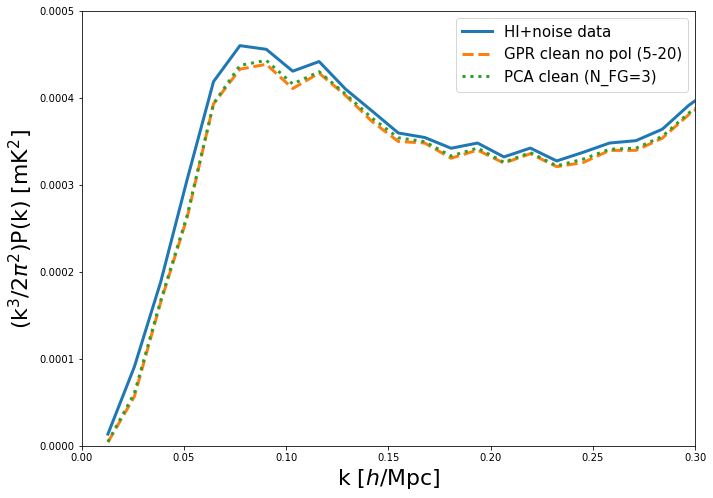

In [17]:
plt.figure(figsize=(11,8))

plt.plot(k, (k*k*k*HIpk)/(2*np.pi*np.pi),ls='solid', lw=3, label = r'HI+noise data')
plt.plot(k, (k*k*k*GPRpk)/(2*np.pi*np.pi),ls='dashed', lw=3, label = r'GPR clean no pol (5-20)')
plt.plot(k, (k*k*k*pca3pk)/(2*np.pi*np.pi),ls='dotted',lw=3, label = r'PCA clean (N_FG=3)')

plt.legend(fontsize=15)
plt.xlim(0,0.3)
plt.ylim(0,0.0005)
plt.ylabel('(k$^3$/2$\pi^2$)P(k) [mK$^2$]', fontsize=22)
plt.xlabel('k [$h$/Mpc]', fontsize=22)